In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Training settings
batch_size = 64

In [30]:
# MNIST Dataset
train_dataset = datasets.FashionMNIST(root='./data/',
                               train=True, # represents the training section of the data
                               transform=transforms.ToTensor(),
                               download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11065097.23it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204741.81it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3800904.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3920166.48it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [31]:
test_dataset = datasets.FashionMNIST(root='./data/',
                              train=False, #validation set
                              transform=transforms.ToTensor())


In [32]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [33]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [34]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        '''
        nn.Conv2d(in_channels, out_channels, kernel_size)
        in_channels - number of channels of the input
                    - for greyscale images we have 1, or basically a single channel
                    - for RGB images we have 3 channels and for sattelite date number can be higher.

        out_channels - number of different filters applied to the input images and the resulting images from the operation
                     - in our case is 10 at first conv, so we will have 10 different images as a result of filters applied
        '''
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2) # apply max pool with a window of 2X2
        self.fc = nn.Linear(320, 10) # final fully-connected layer

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return x

In [35]:
model = Net().cuda()

In [36]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)


In [37]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [38]:
train_loss = []
validation_loss=[]
validation_accuracy=[]
train_accuracy=[]

In [39]:
def train(epoch):
    model.train()
    correct = 0
    losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss.append(sum(losses)/len(losses))
    train_accuracy.append(correct* 100./len(train_loader.dataset))

In [40]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    losses=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            # sum up batch loss
            loss= criterion(output, target)
            losses.append(loss.item())
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss = sum(losses)/len(losses)
        validation_loss.append(test_loss)
        validation_accuracy.append(100. * correct/len(test_loader.dataset))
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


In [41]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295403
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.309473
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.774395
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.860669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.794048
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.830895
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.516144
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.570803
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.652490
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.700302
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.614375
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.588552
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.512423
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.629068
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.437448
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.662889
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.513218
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.566081
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.395005
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.538729
Train Epoch: 1 [12800/60000 (

In [42]:
#matplotlib este folosit pentru a realiza grafice
import matplotlib.pyplot as plt
plt.style.use("ggplot")

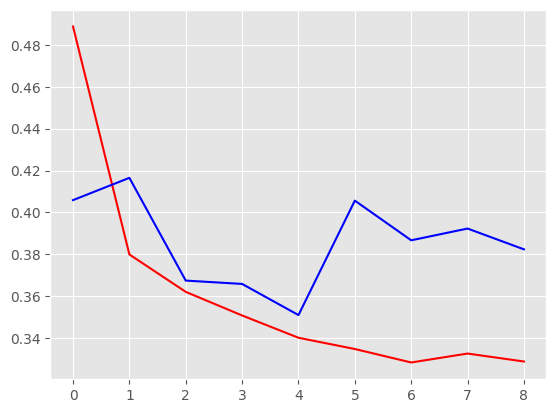

In [43]:
# Printăm comparativ cu roșu loss-ul de pe setul de validare și cu albastru loss-ul de pe setul de validare.
plt.plot(train_loss, "r-", validation_loss, "b-")

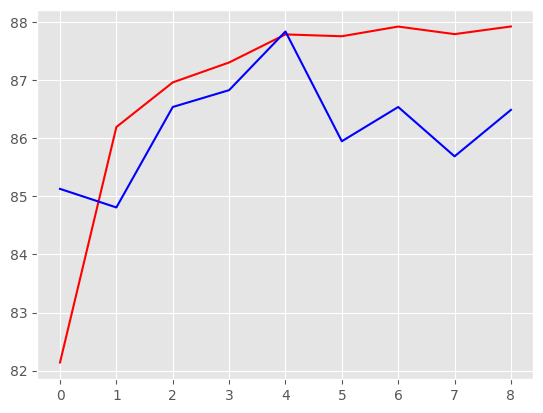

In [44]:
plt.plot(train_accuracy, "r-", validation_accuracy, "b-")